In [46]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import utils
from bs4 import BeautifulSoup

import nltk

In [2]:
products = pd.read_csv('data/DreamMarket_master_product.csv')

C:\Users\morga\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# utils.plot_null_val_heatmap(products, 'Null Values of Product Dataset')

## Reference Objects

In [4]:
country_map = {'united states': 'usa', 'united kingdom' :'uk', 'dutch': 'netherlands', 'ww': 'worldwide', 'holland': 'netherlands', 'amsterdam': 'netherlands', 'nederland': 'netherlands',
              'españa': 'spain', 'au': 'australia', 'deutschland': 'germany'}

In [ ]:
def stanardize_locations(loc, dct):
        
    loc_lower = loc.lower()
    loc_mapped = dct[loc_lower]

## Functions - Add to utils.py

In [45]:
for c in products_v2['ship_from'].unique():
    print(c)

-
CANADA
dutch
Worldwide
AU
WW
pm
Philippines
netherlands
China
Danmark spain uk
UK
Europe
EUROPE
Netherlands
Germany
THE NETHERLAND
europe
canada
United Kingdom
USA
Philippines USA
Canada
Australia Europe
United States
US
france
Tor
EU
California USA
Germany Holland
North America
worldwide
Spain Germany Netherlands
Brazil south american
holland amsterdam
Amsterdam
Australia
NL DE
GERMANY EASTERN EUROPE
Belgium
holland
Internet
Digital Delivery
Holland
Yes
usa
U S
germany
UNITED KINGDOM
Uk
E U
France
NL
The Netherlands
DEUTSCHLAND GERMANY EUROPE
USA California
U K
eu
Digital Download
AUSTRALIA
Europa
Czech republic
Japan
Poland
ww
Worlwide
Dutch
uk
the netherlands
United Snakes of Captivity
digital
FRANCE
United kindom
PM
GERMANY
NEDERLAND
Hongkong
UK WW
The netherlands
Online
United States of America
CHINA
U S A
Austria
Netherlands Germany
india
Nederland
NETHERLANDS
debuyerking
australia
japan
India
china
Germany Belgium
Norge Danmark
the Netherlands
Oildale aka Oilville USA
suboxone

## Review Raw Data

In [5]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130936 entries, 0 to 130935
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   seqNo             39473 non-null   float64
 1   product_name      130936 non-null  object 
 2   category          130936 non-null  object 
 3   description       130936 non-null  object 
 4   shipping_options  130936 non-null  object 
 5   keywords          130936 non-null  object 
 6   seller_name       130936 non-null  object 
 7   price             130936 non-null  object 
 8   payment_method    130936 non-null  object 
 9   sold_since        130936 non-null  object 
 10  ends_in           130936 non-null  object 
 11  quantity_sold     130936 non-null  object 
 12  quantity_left     130936 non-null  object 
 13  refundPolicy      130936 non-null  object 
 14  market_name       130936 non-null  object 
 15  ship_from         130932 non-null  object 
 16  ship_to           13

In [6]:
products.head()

,seqNo,product_name,category,description,shipping_options,keywords,seller_name,price,payment_method,sold_since,ends_in,quantity_sold,quantity_left,refundPolicy,market_name,ship_from,ship_to,idproduct
0,1.0,503 - Forwarding failure (Privoxy@localhost),-,-,-,-,-,-,-,-,-,-,-,-,Dream,-,-,NaN
1,2.0,OG KUSH 1/2 OZ $125 AAAA+,Drugs \n\t\t41793,OG Kush makes up the genetic backbone of West ...,\n\n\n$15.99\t\t\t\t\t\nCANADA WIDE\n\n\n\n\n\...,-,GWLOVE,$125,Escrow Yes,-,-,-,-,-,Dream,CANADA,Worldwide Worldwide,NaN
2,3.0,Dream Market Login - Featured anonymous market...,-,-,-,-,-,-,-,-,-,-,-,-,Dream,-,-,NaN
3,4.0,Every drug available on request,Drugs \n\t\t41804,Every kind of medicine I can arrange . Send me...,-,-,Hectorstuff,$1,Escrow Yes,-,-,-,-,-,Dream,dutch,Worldwide Worldwide,NaN
4,5.0,"Debug, Learn how crack windows",Digital Goods \n\t\t29334,"Debug, Learn how crack windows",-,-,darkmarket,$1,Escrow Yes,-,-,-,-,-,Dream,Worldwide,Worldwide Worldwide,NaN


In [7]:
cols_to_review = ['sold_since', 'ends_in', 'quantity_sold', 'quantity_left', 'refundPolicy', 'keywords', 'market_name']
for x in cols_to_review:
    print('{}: {}'.format(x, products[x].unique()))

sold_since: ['-']
ends_in: ['-']
quantity_sold: ['-']
quantity_left: ['-']
refundPolicy: ['-']
keywords: ['-']
market_name: ['Dream']


## Text Cleaning

In [23]:
products_v2 = products.drop(cols_to_review, axis=1)

In [24]:
# Create sale year of posting
products_v2['is_2016'] = products_v2['idproduct'].isnull()
products_v2['year_posted'] = products_v2['is_2016'].apply(lambda x: 2016 if True else 2017)
products_v2.drop('is_2016', axis=1, inplace=True)

# Convert listing price from string to float.
products_v2['adj_price'] = products_v2['price'].apply(lambda x: utils.convert_price_to_float(x))

In [25]:
# Seperate category name and ID.
products_v2['category_revised'] = products_v2['category'].str.replace(r'\n', '')
products_v2['category_revised'] = products_v2['category_revised'].str.replace('\t', '')
products_v2['category_name'] = products_v2['category_revised'].str.findall(r'[a-zA-Z ]')
products_v2['category_name'] = products_v2['category_name'].apply(lambda x: ''.join(x))
products_v2['category_name'] = products_v2['category_name'].apply(lambda x: utils.replace_empty_cell_with_nan(x))


products_v2['category_id'] = products_v2['category_revised'].str.findall(r'[\d+ ]')
products_v2['category_id'] = products_v2['category_id'].apply(lambda x: ''.join(x))
products_v2['category_id'] = products_v2['category_id'].apply(lambda x: utils.replace_empty_cell_with_nan(x))

products_v2.drop('category_revised', axis=1, inplace=True)

In [26]:
products_v2.head()

,seqNo,product_name,category,description,shipping_options,seller_name,price,payment_method,ship_from,ship_to,idproduct,year_posted,adj_price,category_name,category_id
0,1.0,503 - Forwarding failure (Privoxy@localhost),-,-,-,-,-,-,-,-,NaN,2016,NaN,NaN,NaN
1,2.0,OG KUSH 1/2 OZ $125 AAAA+,Drugs \n\t\t41793,OG Kush makes up the genetic backbone of West ...,\n\n\n$15.99\t\t\t\t\t\nCANADA WIDE\n\n\n\n\n\...,GWLOVE,$125,Escrow Yes,CANADA,Worldwide Worldwide,NaN,2016,125.0,Drugs,41793
2,3.0,Dream Market Login - Featured anonymous market...,-,-,-,-,-,-,-,-,NaN,2016,NaN,NaN,NaN
3,4.0,Every drug available on request,Drugs \n\t\t41804,Every kind of medicine I can arrange . Send me...,-,Hectorstuff,$1,Escrow Yes,dutch,Worldwide Worldwide,NaN,2016,1.0,Drugs,41804
4,5.0,"Debug, Learn how crack windows",Digital Goods \n\t\t29334,"Debug, Learn how crack windows",-,darkmarket,$1,Escrow Yes,Worldwide,Worldwide Worldwide,NaN,2016,1.0,Digital Goods,29334


---
## Extract Info From Product Name

**Regex Examples:**
```
df['method_1'] = df['text'].str.findall(r'\d{1,2}[/-]\d{1,2}[/-]\d{2,4}')
df['method_2'] = df['text'].str.findall(r'(\d{1,2}) (Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]* (\d{2,4})')
df['method_3'] = df['text'].str.findall(r'(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*[.]* (\d{1,2})[,]* (\d{2,4})')
df['method_4'] = df['text'].str.findall(r'(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*[.,]* \d{4}')
df['method_5'] = df['text'].str.findall(r'\d{1,2}[/-]\d{4}')
df['method_6'] = df['text'].str.findall(r'\d{4}')
```    

In [27]:
products_v2['prod_name_arr'] = products_v2['product_name'].apply(lambda x: utils.replace_split_text(x, r"[^a-zA-Z0-9$%.@'_]"," "))

In [28]:
products_v2.head()

,seqNo,product_name,category,description,shipping_options,seller_name,price,payment_method,ship_from,ship_to,idproduct,year_posted,adj_price,category_name,category_id,prod_name_arr
0,1.0,503 - Forwarding failure (Privoxy@localhost),-,-,-,-,-,-,-,-,NaN,2016,NaN,NaN,NaN,"[Forwarding, failure, Privoxy@localhost, ]"
1,2.0,OG KUSH 1/2 OZ $125 AAAA+,Drugs \n\t\t41793,OG Kush makes up the genetic backbone of West ...,\n\n\n$15.99\t\t\t\t\t\nCANADA WIDE\n\n\n\n\n\...,GWLOVE,$125,Escrow Yes,CANADA,Worldwide Worldwide,NaN,2016,125.0,Drugs,41793,"[KUSH, 1, 2, OZ, $125, AAAA, ]"
2,3.0,Dream Market Login - Featured anonymous market...,-,-,-,-,-,-,-,-,NaN,2016,NaN,NaN,NaN,"[Market, Login, Featured, anonymous, marketplace]"
3,4.0,Every drug available on request,Drugs \n\t\t41804,Every kind of medicine I can arrange . Send me...,-,Hectorstuff,$1,Escrow Yes,dutch,Worldwide Worldwide,NaN,2016,1.0,Drugs,41804,"[drug, available, on, request]"
4,5.0,"Debug, Learn how crack windows",Digital Goods \n\t\t29334,"Debug, Learn how crack windows",-,darkmarket,$1,Escrow Yes,Worldwide,Worldwide Worldwide,NaN,2016,1.0,Digital Goods,29334,"[Learn, how, crack, windows]"


---
## Extract Info From Description


In [29]:
products_v2['desc_arr'] = products_v2['description'].apply(lambda x: utils.replace_split_text(x, r"[^a-zA-Z0-9$%.'/_]"," "))




In [30]:
products_v2.iloc[:15, :]

,seqNo,product_name,category,description,shipping_options,seller_name,price,payment_method,ship_from,ship_to,idproduct,year_posted,adj_price,category_name,category_id,prod_name_arr,desc_arr
0,1.0,503 - Forwarding failure (Privoxy@localhost),-,-,-,-,-,-,-,-,NaN,2016,NaN,NaN,NaN,"[Forwarding, failure, Privoxy@localhost, ]",[]
1,2.0,OG KUSH 1/2 OZ $125 AAAA+,Drugs \n\t\t41793,OG Kush makes up the genetic backbone of West ...,\n\n\n$15.99\t\t\t\t\t\nCANADA WIDE\n\n\n\n\n\...,GWLOVE,$125,Escrow Yes,CANADA,Worldwide Worldwide,NaN,2016,125.00,Drugs,41793,"[KUSH, 1, 2, OZ, $125, AAAA, ]","[Kush, makes, up, the, genetic, backbone, of, ..."
2,3.0,Dream Market Login - Featured anonymous market...,-,-,-,-,-,-,-,-,NaN,2016,NaN,NaN,NaN,"[Market, Login, Featured, anonymous, marketplace]",[]
3,4.0,Every drug available on request,Drugs \n\t\t41804,Every kind of medicine I can arrange . Send me...,-,Hectorstuff,$1,Escrow Yes,dutch,Worldwide Worldwide,NaN,2016,1.00,Drugs,41804,"[drug, available, on, request]","[kind, of, medicine, I, can, arrange, ., Send,..."
4,5.0,"Debug, Learn how crack windows",Digital Goods \n\t\t29334,"Debug, Learn how crack windows",-,darkmarket,$1,Escrow Yes,Worldwide,Worldwide Worldwide,NaN,2016,1.00,Digital Goods,29334,"[Learn, how, crack, windows]","[Learn, how, crack, windows, ]"
5,6.0,503 - Forwarding failure (Privoxy@localhost),-,-,-,-,-,-,-,-,NaN,2016,NaN,NaN,NaN,"[Forwarding, failure, Privoxy@localhost, ]",[]
6,7.0,503 - Forwarding failure (Privoxy@localhost),-,-,-,-,-,-,-,-,NaN,2016,NaN,NaN,NaN,"[Forwarding, failure, Privoxy@localhost, ]",[]
7,8.0,Ketamine HIGH QUALITY(Pharma S-Isomer) 5g,Drugs \n\t\t40803,PRODUCT:\nThis Pharma S-isomer ketamine. Lab ...,\n\n\n$3\t\t\t\t\t\nexpress\n\n\n\n\n\n,CrownBay,$500,Escrow Yes,AU,Australia,NaN,2016,500.00,Drugs,40803,"[HIGH, QUALITY, Pharma, S, Isomer, 5g]","[This, Pharma, S, isomer, ketamine., Lab, test..."
8,9.0,WIFI HACK,Services \n\t\t2220,Crack Any WiFi Password for\nHacking WEP/WPA/W...,\n\n\n$0\t\t\t\t\t\nDigital\n\n\n\n\n\n,BESTSHOP,$3.65,Escrow Yes,WW,Worldwide Europe,NaN,2016,3.65,Services,2220,"[HACK, ]","[Any, WiFi, Password, for, Hacking, WEP/WPA/WP..."
9,10.0,Hacked NETFLIX Account,Digital Goods \n\t\t29294,Hacked NETFLIX Account\n\nDon't change the pas...,-,Hackyboy,$8,Escrow Yes,pm,Worldwide,NaN,2016,8.00,Digital Goods,29294,"[NETFLIX, Account]","[NETFLIX, Account, Don't, change, the, passwor..."


--- 
## Extract Info From Shipping

In [31]:
# Is it better to delay the removal of "\n" and "\t"?
products_v2['shipping_cleaned'] = products_v2['shipping_options'].str.replace('\n', ' ')
products_v2['shipping_cleaned'] = products_v2['shipping_cleaned'].str.replace('\t', ' ')
products_v2['shipping_cleaned'] = products_v2['shipping_cleaned'].apply(lambda x: utils.replace_split_text(x, r"[^a-zA-Z0-9$%.'/_]"," "))

In [47]:
products_v2.iloc[15:20, :]

,seqNo,product_name,category,description,shipping_options,seller_name,price,payment_method,ship_from,ship_to,idproduct,year_posted,adj_price,category_name,category_id,prod_name_arr,desc_arr,shipping_cleaned
15,16.0,Dream Market Login - Featured anonymous market...,-,-,-,-,-,-,-,-,NaN,2016,NaN,NaN,NaN,"[Market, Login, Featured, anonymous, marketplace]",[],[]
16,17.0,Fluor-Modafinil 100g,Drugs \n\t\t41830,Lab tested product purity around 98%.\nDo not ...,\n\n\n$39\t\t\t\t\t\nEMS\n\n\n\n\n\n$59\t\t\t\...,ROCKETCHEM,$490,Escrow Yes,China,Worldwide Europe,NaN,2016,490.00,Drugs,41830,"[Modafinil, 100g]","[tested, product, purity, around, 98%., Do, no...","[$39, EMS, $59, Fedex/TNT, ]"
17,18.0,Listing not found,-,-,-,-,-,-,-,-,NaN,2016,NaN,NaN,NaN,"[not, found]",[],[]
18,19.0,7g ORGANIC Maroc Hashish (sativa),Drugs \n\t\t42072,ONLY 9.99 per GRAM !!!\n\nOrganic Moroccan has...,\n\n\n$0\t\t\t\t\t\n2nd item\n\n\n\n\n\n$2.5\t...,danhash,$69.9,Escrow Yes,Danmark spain uk,Worldwide Europe,NaN,2016,69.90,Drugs,42072,"[ORGANIC, Maroc, Hashish, sativa, ]","[9.99, per, GRAM, Organic, Moroccan, hashish, ...","[$0, 2nd, item, $2.5, WorldMail, World, 5DD, ]"
19,20.0,30 Pills Pain-O-Soma (Carisoprodol) 350mg | UK,Drugs \n\t\t40227,Pain-O-Soma contains Carisoprodol which is a m...,\n\n\n$9.87\t\t\t\t\t\nUK Tracked Post\n\n\n\n...,Mr.Erection,$28.36,Escrow Yes,UK,Europe,NaN,2016,28.36,Drugs,40227,"[Pills, Pain, O, Soma, Carisoprodol, 350mg, UK]","[O, Soma, contains, Carisoprodol, which, is, a...","[$9.87, UK, Tracked, Post, $12.3, EU, Tracked,..."


### Ship From Formatting

In [ ]:
def lower_and_split_string(text):
    '''
    
    
    '''
    
    if type(text) == str:
        text = text.lower()
        text = text.split(' ')
    
    return text

In [49]:
products_v2['ship_from_cleaned'] = products_v2['ship_from'].apply(lambda x: x.lower() if type(x) == str else x)
products_v2['']

In [50]:
products_v2.head()

,seqNo,product_name,category,description,shipping_options,seller_name,price,payment_method,ship_from,ship_to,idproduct,year_posted,adj_price,category_name,category_id,prod_name_arr,desc_arr,shipping_cleaned,ship_from_lower
0,1.0,503 - Forwarding failure (Privoxy@localhost),-,-,-,-,-,-,-,-,NaN,2016,NaN,NaN,NaN,"[Forwarding, failure, Privoxy@localhost, ]",[],[],-
1,2.0,OG KUSH 1/2 OZ $125 AAAA+,Drugs \n\t\t41793,OG Kush makes up the genetic backbone of West ...,\n\n\n$15.99\t\t\t\t\t\nCANADA WIDE\n\n\n\n\n\...,GWLOVE,$125,Escrow Yes,CANADA,Worldwide Worldwide,NaN,2016,125.0,Drugs,41793,"[KUSH, 1, 2, OZ, $125, AAAA, ]","[Kush, makes, up, the, genetic, backbone, of, ...","[$15.99, CANADA, WIDE, $20.99, UNITED, STATES,...",canada
2,3.0,Dream Market Login - Featured anonymous market...,-,-,-,-,-,-,-,-,NaN,2016,NaN,NaN,NaN,"[Market, Login, Featured, anonymous, marketplace]",[],[],-
3,4.0,Every drug available on request,Drugs \n\t\t41804,Every kind of medicine I can arrange . Send me...,-,Hectorstuff,$1,Escrow Yes,dutch,Worldwide Worldwide,NaN,2016,1.0,Drugs,41804,"[drug, available, on, request]","[kind, of, medicine, I, can, arrange, ., Send,...",[],dutch
4,5.0,"Debug, Learn how crack windows",Digital Goods \n\t\t29334,"Debug, Learn how crack windows",-,darkmarket,$1,Escrow Yes,Worldwide,Worldwide Worldwide,NaN,2016,1.0,Digital Goods,29334,"[Learn, how, crack, windows]","[Learn, how, crack, windows, ]",[],worldwide


In [ ]:
def process_location_data(loc):
    '''
    Cleans and splits location data.
    
    '''
    if type(loc) == str:
        
        
        
    
    except: 

In [103]:
products_v2['ship_from_arr'] = products_v2['ship_from'].apply(lambda x: x.split(' ') if type(x) == str else x)
products_v2['has_digital_delivery'] = products_v2['ship_from_arr'].apply(lambda x: 1 if 'digital' in x else 0)

TypeError: argument of type 'float' is not iterable

In [101]:
products_v2.iloc[100100:100110, :]

,seqNo,product_name,category,description,shipping_options,seller_name,price,payment_method,market_name,ship_from,...,year_posted,adj_price,category_str,category_num,desc_arr,prod_name_arr,shipping_cleaned,category_name,category_id,ship_from_ split
100100,NaN,Jack Herer --25 seeds-- FREE SHIPPING,"Drugs, Cannabis, Seeds",Back from Alphabay!\n\nCHEAPEST SEEDS ON THE M...,\n\n\n฿0.00 ($0)\t\t\t\t\t\nEurope (2-10 days)...,hewq123,24.97,Escrow Yes,Dream,Netherlands,...,2016,24.97,Drugs Cannabis Seeds,,"[from, Alphabay, CHEAPEST, SEEDS, ON, THE, MAR...","[Herer, 25, seeds, FREE, SHIPPING]","[0.00, $0, Europe, 2, 10, days, 0.00, $0, Worl...",Drugs Cannabis Seeds,,[Netherlands]
100101,NaN,White Widow --25 seeds-- FREE SHIPPING,"Drugs, Cannabis, Seeds",Back from Alphabay!\n\nCHEAPEST SEEDS ON THE M...,\n\n\n฿0.00 ($0)\t\t\t\t\t\nEurope (2-10 days)...,hewq123,24.96,Escrow Yes,Dream,Netherlands,...,2016,24.96,Drugs Cannabis Seeds,,"[from, Alphabay, CHEAPEST, SEEDS, ON, THE, MAR...","[Widow, 25, seeds, FREE, SHIPPING]","[0.00, $0, Europe, 2, 10, days, 0.00, $0, Worl...",Drugs Cannabis Seeds,,[Netherlands]
100102,NaN,Afghan Seeds -- 200 seeds -- FREE SHIPPING,"Drugs, Cannabis, Seeds",Back from Alphabay!\n\nCHEAPEST SEEDS ON THE M...,\n\n\n฿0.00 ($0)\t\t\t\t\t\nEurope (2-10 days)...,hewq123,159.92,Escrow Yes,Dream,Netherlands,...,2016,159.92,Drugs Cannabis Seeds,,"[from, Alphabay, CHEAPEST, SEEDS, ON, THE, MAR...","[Seeds, 200, seeds, FREE, SHIPPING]","[0.00, $0, Europe, 2, 10, days, 0.00, $0, Worl...",Drugs Cannabis Seeds,,[Netherlands]
100103,NaN,"CHOCOLATE HAZE FEMINIZED ""ROYAL QUEEN SEEDS"" 1...","Drugs, Cannabis, Seeds",WELCOME TO MY STORE!!!\n\nCHOCOLATE HAZE FEMIN...,\n\n\n฿0.00068 ($3)\t\t\t\t\t\nunited kingdom\...,seedsforeveryone,49.97,Escrow Yes,Dream,united kingdom,...,2016,49.97,Drugs Cannabis Seeds,,"[TO, MY, STORE, CHOCOLATE, HAZE, FEMINIZED, RO...","[HAZE, FEMINIZED, ROYAL, QUEEN, SEEDS, 10, SE]","[0.00068, $3, united, kingdom, 0.001134, $5, e...",Drugs Cannabis Seeds,,"[united, kingdom]"
100104,NaN,"ROYAL AK FEMINIZED ""ROYAL QUEEN SEEDS"" 5 SEEDS...","Drugs, Cannabis, Seeds","WELCOME TO MY STORE!!!\n\nROYAL AK FEMINIZED ""...",\n\n\n฿0.000694 ($3)\t\t\t\t\t\nunited kingdom...,seedsforeveryone,28.94,Escrow Yes,Dream,united kingdom,...,2016,28.94,Drugs Cannabis Seeds,,"[TO, MY, STORE, ROYAL, AK, FEMINIZED, ROYAL, Q...","[AK, FEMINIZED, ROYAL, QUEEN, SEEDS, 5, SEEDS,...","[0.000694, $3, united, kingdom, 0.001157, $5, ...",Drugs Cannabis Seeds,,"[united, kingdom]"
100105,NaN,NANOCORE 1.2.2 RAT,"Digital Goods, Software",Additions & Changes:\n======================\n...,\n\n\n฿0.00 (€0)\t\t\t\t\t\ndigital\n\n\n\n\n\n,Johnbronz,2.7,Escrow Yes,Dream,Worldwide,...,2016,2.70,Digital Goods Software,,"[Changes, Feedback, Renamed, Total, label, in,...","[1.2.2, RAT]","[0.00, 0, digital, ]",Digital Goods Software,,[Worldwide]
100106,NaN,"ROYAL CHEESE FEMINIZED ""ROYAL QUEEN SEEDS"" 5 S...","Drugs, Cannabis, Seeds",WELCOME TO MY STORE!!!\n\nROYAL CHEESE FEMINIZ...,\n\n\n฿0.000703 ($3)\t\t\t\t\t\nunited kingdom...,seedsforeveryone,27.99,Escrow Yes,Dream,united kingdom,...,2016,27.99,Drugs Cannabis Seeds,,"[TO, MY, STORE, ROYAL, CHEESE, FEMINIZED, ROYA...","[CHEESE, FEMINIZED, ROYAL, QUEEN, SEEDS, 5, SE...","[0.000703, $3, united, kingdom, 0.00117, $5, e...",Drugs Cannabis Seeds,,"[united, kingdom]"
100107,NaN,Netflix Premium Account [LIFETIME + FREEBIES],"Digital Goods, Fraud Related, Accounts",[CHEAPEST ON ALPHABAY + Rest of Darkweb]\n\nIf...,-,xfuckx,3.99,Escrow Yes,Dream,Worldwide digital delivery,...,2016,3.99,Digital Goods Fraud Related Accounts,,"[CHEAPEST, ON, ALPHABAY, Rest, of, Darkweb, If...","[Premium, Account, LIFETIME, FREEBIES, ]",[],Digital Goods Fraud Related Accounts,,"[Worldwide, digital, delivery]"
100108,NaN,Deezer ACCOUNTS LIFETIME,"Digital Goods, Fraud Related, Accounts",[CHEAPEST ON ALPHABAY + Rest of Darkweb]\n\nIf...,-,xfuckx,1.49,Escrow Yes,Dream,Worldwide digital delivery,...,2016,1.49,Digital Goods Fraud Relat

In [40]:
products_v2['ship_from'].unique()

array(['-', 'CANADA', 'dutch', 'Worldwide', 'AU', 'WW', 'pm',
       'Philippines', 'netherlands', 'China', 'Danmark spain uk', 'UK',
       'Europe', 'EUROPE', 'Netherlands', 'Germany', 'THE NETHERLAND',
       'europe', 'canada', 'United Kingdom', 'USA', 'Philippines USA',
       'Canada', 'Australia Europe', 'United States', 'US', 'france',
       'Tor', 'EU', 'California USA', 'Germany Holland', 'North America',
       'worldwide', 'Spain Germany Netherlands', 'Brazil south american',
       'holland amsterdam', 'Amsterdam', 'Australia', 'NL DE',
       'GERMANY EASTERN EUROPE', 'Belgium', 'holland', 'Internet',
       'Digital Delivery', 'Holland', 'Yes', 'usa', 'U S', 'germany',
       'UNITED KINGDOM', 'Uk', 'E U', 'France', 'NL', 'The Netherlands',
       'DEUTSCHLAND GERMANY EUROPE', 'USA California', 'U K', 'eu',
       'Digital Download', 'AUSTRALIA', 'Europa', 'Czech republic',
       'Japan', 'Poland', 'ww', 'Worlwide', 'Dutch', 'uk',
       'the netherlands', 'United Snak

In [39]:
products_v2[products_v2['category_name'] == 'Services '].tail(20)

,seqNo,product_name,category,description,shipping_options,seller_name,price,payment_method,ship_from,ship_to,idproduct,year_posted,adj_price,category_name,category_id,prod_name_arr,desc_arr,shipping_cleaned
37762,37763.0,1 x SPOTIFY ACCOUNT,Services \n\t\t2189,LIFETIME SPOTIFY ACCOUNT\nREPLACEMENT AVAILABL...,\n\n\n$2\t\t\t\t\t\n1 x account\n\n\n\n\n\n$13...,ultimatum2016,$1,Escrow Yes,Worldwide,Worldwide Worldwide,NaN,2016,1.00,Services,2189,"[x, SPOTIFY, ACCOUNT]","[SPOTIFY, ACCOUNT, REPLACEMENT, AVAILABLE, IF,...","[$2, 1, x, account, $13, 5, x, accounts, $27, ..."
37768,37769.0,Tip Jar :),Services \n\t\t2209,This is so customers can tip me when there hap...,\n\n\n$0\t\t\t\t\t\nFree 1 second shipping!!!!...,GoodCatKilla,$5,Escrow Yes,USA,United States,NaN,2016,5.00,Services,2209,"[Jar, ]","[is, so, customers, can, tip, me, when, there,...","[$0, Free, 1, second, shipping, ]"
37856,37857.0,Videobox Premium Porn Account,Services \n\t\t2218,Videobox Premium Porn Account,\n\n\n$0\t\t\t\t\t\nDigital\n\n\n\n\n\n,montana193,$3,Escrow Yes,Yes,worldwide,NaN,2016,3.00,Services,2218,"[Premium, Porn, Account]","[Premium, Porn, Account, ]","[$0, Digital, ]"
38135,38136.0,Sweden Drivers Licence,Services \n\t\t2199,[>>] PROMO UNTIL THE END OF THIS MONTH\n[>>] B...,\n\n\n$5\t\t\t\t\t\nAir Mail\n\n\n\n\n\n,mikedelacruz,$199,Escrow Yes,Yes,Worldwide,NaN,2016,199.00,Services,2199,"[Drivers, Licence]","[PROMO, UNTIL, THE, END, OF, THIS, MONTH, BUY,...","[$5, Air, Mail, ]"
38138,38139.0,Tennessee Drivers License Template,Services \n\t\t2193,Tennessee Drivers License Template\n\nI will s...,-,color,$12,Escrow Yes,USA,Worldwide,NaN,2016,12.00,Services,2193,"[Drivers, License, Template]","[Drivers, License, Template, I, will, send, yo...",[]
38220,38221.0,Custom listing for dark33,Services \n\t\t2202,Custom listing for dark33,-,passman,$1800,Escrow No,Worldwide,Worldwide Worldwide,NaN,2016,1800.00,Services,2202,"[listing, for, dark33]","[listing, for, dark33, ]",[]
38308,38309.0,20 EUR ANON CASH IN MAIL (EU ONLY),Services \n\t\t2223,We accept bitcoin and send you cash in mail at...,\n\n\n$2.99\t\t\t\t\t\npost\n\n\n\n\n\n,danhash,$30,Escrow No,eu world uk,Worldwide Europe,NaN,2016,30.00,Services,2223,"[EUR, ANON, CASH, IN, MAIL, EU, ONLY, ]","[accept, bitcoin, and, send, you, cash, in, ma...","[$2.99, post, ]"
38587,38588.0,custom for jenn*****,Services \n\t\t2189,custom for jenn*****,-,europe,$150,Escrow Yes,Worldwide,Worldwide Worldwide,NaN,2016,150.00,Services,2189,"[for, jenn, ]","[for, jenn, ]",[]
38661,38662.0,Michigan Drivers License Template,Services \n\t\t2193,Michigan Drivers License Template\n\nI will se...,-,color,$12,Escrow Yes,USA,Worldwide,NaN,2016,12.00,Services,2193,"[Drivers, License, Template]","[Drivers, License, Template, I, will, send, yo...",[]
38672,38673.0,Amazon refund for Chipotle123,Services \n\t\t2189,15% escrow,-,ultimatum2016,$63.6,Escrow Yes,Worldwide,Worldwide Worldwide,NaN,2016,63.60,Services,2189,"[refund, for, Chipotle123]","[escrow, ]",[]


In [19]:
products_v2['shipping_options_revised'] = products_v2['shipping_options'].str.replace(r'\n', ' ')
products_v2['shipping_options_revised'] = products_v2['shipping_options_revised'].str.replace('\t', ' ')

In [20]:
for i in products_v2.iloc[11:20, -1:].values:
    print(i)

['-']
['-']
['   $0      Priority shipping Western and Northern Europe      $0      Priority shipping  Eastern and  Southern Europe      $0       combined order only when ordering mulitiple strains to prevent paying twice      $3.147      Priority shipping  Eastern and  Southern Europe      ']
['-']
['-']
['   $39      EMS      $59      Fedex/TNT      ']
['-']
['   $0      2nd item      $2.5      WorldMail (World) 5DD      ']
['   $9.87      UK Tracked Post      $12.3      EU Tracked Post      ']


In [21]:
for x in products['description'][50: 70]:
    print(x)

5 gram pure SPEEDPASTE 72-74% PURITY - FREE SHIPMENT + TRACK&TRACE 
Lemon Haze is a hybrid of Lemon Skunk and Amnesia Haze, both of which are sativas that feature a prominent lemon flavor and aroma of their own. It has one of the higher THC contents at roughly 25 % with a CBD content of around 0.88 percent. Indeed, the strain is so potent that it won the 2008 High Times Cannabis Cup, which greatly increased its popularity.


Lemon Haze has been characterized as smelling of fresh peeled lemon slices with a similar taste. Its buds appear to be green and yellow with amber hairs on the trichomes, giving it the yellow tint. 

The Lemon Haze strain is popular for  its ability to make people feel happy, euphoric, and uplifted.


"There are not many strains better than this one Jamie Oliver couldn't make a better tasting product, that shit was magical"


Enjoy....


* by ordering we expect you to have read and agreed with the terms on our profile

 
-
                        Gomorra Amsterdam 

## EDA

In [82]:
utils.stats_summary(products_v2['adj_price'])

STATS SUMMARY:
Mean:  1471.6691700309912
Median:  32.0
Std. Dev.:  226317.9385588906
Max value:  76949230.0
Min value:  0.0
# of Obs.:  130936


# - Goods Less Than $100:  76638
% - Total Good Less Than $100: 58.5%


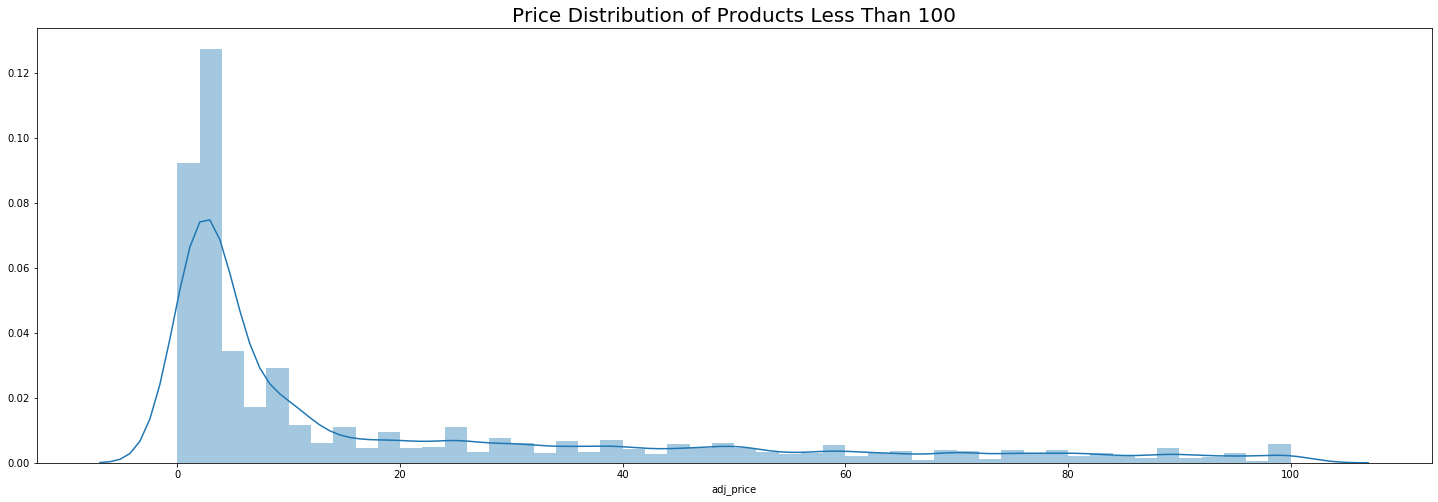

In [84]:
plt.figure(figsize=(25,8))
less_than_100 = products_v2[products_v2['adj_price'] < 100]['adj_price']
sns.distplot(less_than_100)
plt.title('Price Distribution of Products Less Than 100', fontsize= 20);
print('# - Goods Less Than $100: ', len(less_than_100))
print('% - Total Good Less Than $100: {:.1%}'.format(len(less_than_100) / products.shape[0]))

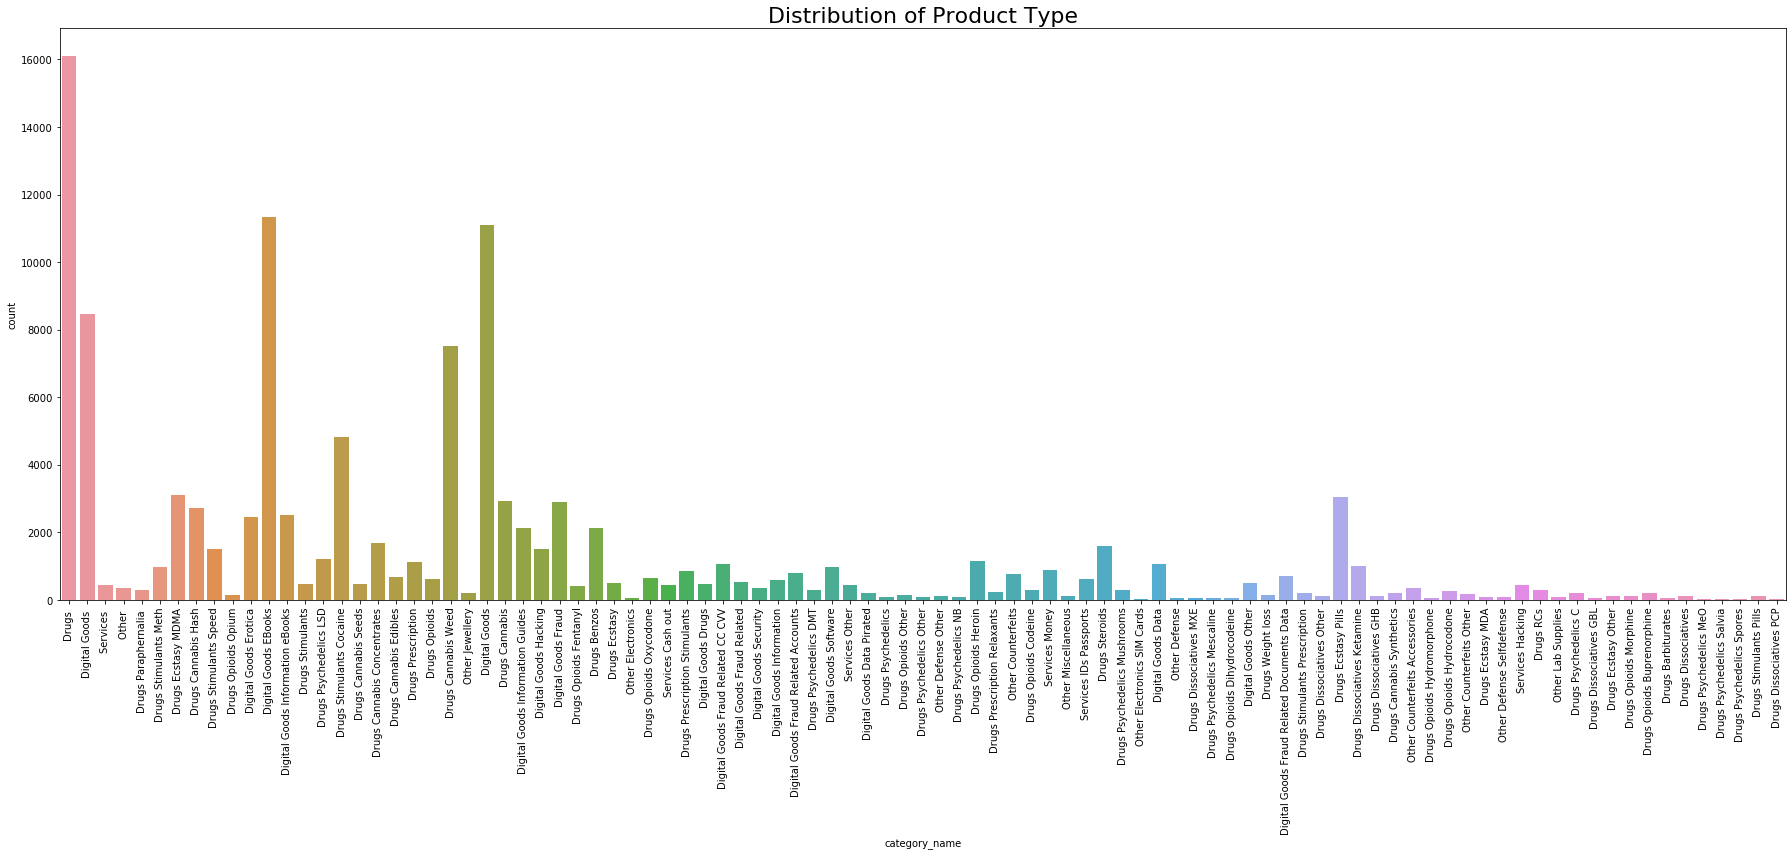

In [90]:
fig, ax = plt.subplots(figsize=(25,12))
ax = sns.countplot(x='category_name', data=products_v2)
ax.set_title('Distribution of Product Type', fontsize=22)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout();

In [91]:
products_v2[products_v2['category_name'] == 'Digital Goods']

,seqNo,product_name,category,description,shipping_options,seller_name,price,payment_method,market_name,ship_from,...,year_posted,adj_price,category_revised,category_str,category_num,desc_arr,prod_name_arr,shipping_cleaned,category_name,category_id
39577,NaN,100% Anonymous,Digital Goods,100% Anonymous\n\nStaying anonymous and safe o...,-,OnePiece,85.83,Escrow Yes,Dream,Worldwide,...,2016,85.83,Digital Goods,Digital Goods,,"[Anonymous, Staying, anonymous, and, safe, onl...",[Anonymous],[],Digital Goods,
39644,NaN,Hooter Hoover Vacuum Sniffer Bullet Rocket Sun,Digital Goods,pack of 1. \n,\n\n\n฿0.001866 ($8)\t\t\t\t\t\nAustralia Stan...,stiffstyles,9.0,Escrow No,Dream,Australia,...,2016,9.00,Digital Goods,Digital Goods,,"[of, 1., ]","[Hoover, Vacuum, Sniffer, Bullet, Rocket, Sun]","[0.001866, $8, Australia, Standard, 0.00466, $...",Digital Goods,
39646,NaN,3X Snuff Kits,Digital Goods,"Black suede roll, with compartments and velcro...",\n\n\n฿0.002565 ($11)\t\t\t\t\t\nEU Standard\n...,stiffstyles,28.99,Escrow No,Dream,Spain,...,2016,28.99,Digital Goods,Digital Goods,,"[suede, roll, with, compartments, and, velcro,...","[Snuff, Kits]","[0.002565, $11, EU, Standard, 0.00373, $16, Re...",Digital Goods,
39651,NaN,Ajax Stash Can,Digital Goods,Looks and feels perfectly identical. \n,\n\n\n฿0.001827 ($8)\t\t\t\t\t\nAustralia Stan...,stiffstyles,28.98,Escrow No,Dream,Australia,...,2016,28.98,Digital Goods,Digital Goods,,"[and, feels, perfectly, identical., ]","[Stash, Can]","[0.001827, $8, Australia, Standard, 0.00456, $...",Digital Goods,
39748,NaN,SNUFF metal hoover/ FREE shipping,Digital Goods,material: metal\ncolour: gold or silver\nsize:...,\n\n\n฿0.00 ($0)\t\t\t\t\t\nFREE SHIPPING worl...,LAMBORGHINI,9.99,Escrow Yes,Dream,EU,...,2016,9.99,Digital Goods,Digital Goods,,"[metal, colour, gold, or, silver, size, 5cm, F...","[metal, hoover, FREE, shipping]","[0.00, $0, FREE, SHIPPING, worldwide, ]",Digital Goods,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130842,NaN,2017 Learn carding from mobile phone,Digital Goods,The Mega Mobile Carding Set Up Guide Turn Y...,-,geekgorilla,4.99,Escrow Yes,Dream,Worldwide,...,2016,4.99,Digital Goods,Digital Goods,,"[The, Mega, Mobile, Carding, Set, Up, Guide, T...","[Learn, carding, from, mobile, phone]",[],Digital Goods,
130843,NaN,Custom for nortonkingdom,Digital Goods,\n,\n\n\n฿0.00 (€0)\t\t\t\t\t\nGermany Express\n\...,drogenimporteure,585.65,Escrow Yes,Dream,Germany,...,2016,585.65,Digital Goods,Digital Goods,,[],"[for, nortonkingdom]","[0.00, 0, Germany, Express, ]",Digital Goods,
130913,NaN,2000 2MG XANAX BARS BEST QUALITY FOR SALE,Digital Goods,"XANAX 2MGs ><><><$5 per PILL, WE OFFER FR...",-,medsman,3497.88,Escrow Yes,Dream,Yes,...,2016,3497.88,Digital Goods,Digital Goods,,"[XANAX, 2MGs, $5, per, PILL, WE, OFFER, FROM, ...","[2MG, XANAX, BARS, BEST, QUALITY, FOR, SALE, ]",[],Digital Goods,
130914,NaN,1000 XANAX 2MG BEST QUALITY PHARMA BRAND FOR S...,Digital Goods,"XANAX 2MGs ><><><$5 per PILL, WE OFFER FR...",-,medsman,2496.28,Escrow Yes,Dream,Yes,...,2016,2496.28,Digital Goods,Digital Goods,,"[XANAX, 2MGs, $5, per, PILL, WE, OFFER, FROM, ...","[XANAX, 2MG, BEST, QUALITY, PHARMA, BRAND, FOR...",[],Digital Goods,
